## Code for training the models: TF-IDF + Ridge Regression, DistilBERT Transformer and BiLSTM


In [1]:
import inputs
!pip install torch transformers datasets scikit-learn scipy pandas matplotlib seaborn -U accelerate


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import spearmanr

In [3]:
# LOAD DATA
df = pd.read_csv("data/Essays.csv")

df = df[["full_text", "score"]].dropna()

print(df.head())
print("\nScore distribution:")
print(df["score"].value_counts().sort_index())

                                           full_text  score
0  Many people have car where they live. The thin...      3
1  I am a scientist at NASA that is discussing th...      3
2  People always wish they had the same technolog...      4
3  We all heard about Venus, the planet without a...      4
4  Dear, State Senator\n\nThis is a letter to arg...      3

Score distribution:
score
1    1252
2    4723
3    6280
4    3926
5     970
6     156
Name: count, dtype: int64


In [4]:
# SPLITTING DATA INTO 70% TRAIN, 15% validation, 15% Test
train_val, test = train_test_split(
    df,
    test_size=0.15,
    stratify=df["score"],
    random_state=42
)

train, val = train_test_split(
    train_val,
    test_size=0.176,
    stratify=train_val["score"],
    random_state=42
)

print("Train:", len(train))
print("Val:", len(val))
print("Test:", len(test))

Train: 12121
Val: 2589
Test: 2597


In [5]:
## MODEL 1: TF-IDF + Ridge

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=20000,
    min_df=5
)

X_train = vectorizer.fit_transform(train["full_text"])
X_val = vectorizer.transform(val["full_text"])
X_test = vectorizer.transform(test["full_text"])

y_train = train["score"].values
y_val = val["score"].values
y_test = test["score"].values

In [6]:
# Training Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",None


In [7]:
# Evaluate Ridge
def evaluate_model(y_true, y_pred_continuous):

    y_pred_rounded = np.clip(np.round(y_pred_continuous), 1, 5)

    qwk = cohen_kappa_score(y_true, y_pred_rounded, weights="quadratic")
    mae = mean_absolute_error(y_true, y_pred_continuous)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_continuous))
    spearman = spearmanr(y_true, y_pred_continuous).correlation

    return qwk, mae, rmse, spearman

# Validation
val_preds = ridge.predict(X_val)
val_results = evaluate_model(y_val, val_preds)

print("Ridge Validation Results")
print("QWK:", val_results[0])
print("MAE:", val_results[1])
print("RMSE:", val_results[2])
print("Spearman:", val_results[3])

Ridge Validation Results
QWK: 0.7315135884289429
MAE: 0.5119704570439847
RMSE: 0.6460413310854813
Spearman: 0.7823438593834126


In [8]:
# FINAL TEST EVALUATION (Ridge)
test_preds = ridge.predict(X_test)
test_results_ridge = evaluate_model(y_test, test_preds)

print("Ridge Test Results")
print("QWK:", test_results_ridge[0])
print("MAE:", test_results_ridge[1])
print("RMSE:", test_results_ridge[2])
print("Spearman:", test_results_ridge[3])

Ridge Test Results
QWK: 0.7302469914738804
MAE: 0.5061107001775033
RMSE: 0.6347589624731087
Spearman: 0.7860120113572238


In [22]:
feature_names = vectorizer.get_feature_names_out()
coefficients = ridge.coef_

top_positive = np.argsort(coefficients)[-10:]
top_negative = np.argsort(coefficients)[:10]

print("Top Positive n-grams:")
for i in reversed(top_positive):
    print(feature_names[i], coefficients[i])

print("\nTop Negative n-grams:")
for i in top_negative:
    print(feature_names[i], coefficients[i])

Top Positive n-grams:
the 2.358662481281981
to 1.9439689631000363
of 1.9408317022234218
and 1.7817337677606035
these 1.7668227324955947
this 1.7015452370884605
could 1.662345650309142
students 1.6591786544894926
student 1.5936863566995292
would 1.5579655687327287

Top Negative n-grams:
the nasa -1.0320210808743102
year -1.0000427437989943
suburbs -0.9028602976487398
stuff -0.8964869815748442
this article -0.823404356722663
painting -0.7818349287401821
but some -0.7805429570501965
of carbon -0.7680573205138997
it so -0.75694039473443
is natural -0.7471734035172221


In [10]:
# MODEL 2: DistilBERT Transformer

# Import transformer Tools
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

In [11]:
# Convert to HuggingFace Dataset
train_ds = Dataset.from_pandas(train.reset_index(drop=True))
val_ds = Dataset.from_pandas(val.reset_index(drop=True))
test_ds = Dataset.from_pandas(test.reset_index(drop=True))



In [12]:
## FOR MAC DEBUGGING
from datasets import Value

train_ds = train_ds.rename_column("score", "labels")
val_ds = val_ds.rename_column("score", "labels")
test_ds = test_ds.rename_column("score", "labels")

train_ds = train_ds.cast_column("labels", Value("float32"))
val_ds = val_ds.cast_column("labels", Value("float32"))
test_ds = test_ds.cast_column("labels", Value("float32"))

Casting the dataset:   0%|          | 0/12121 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2589 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2597 [00:00<?, ? examples/s]

In [14]:
# Tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

MAX_LENGTH = 512

def tokenize(batch):
    return tokenizer(
        batch["full_text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)


train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/12121 [00:00<?, ? examples/s]

Map:   0%|          | 0/2589 [00:00<?, ? examples/s]

Map:   0%|          | 0/2597 [00:00<?, ? examples/s]

In [15]:
# LOAD MODEL (Regression)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=1,
    problem_type="regression"
)


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [16]:
# Metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.flatten()

    preds_rounded = np.clip(np.round(preds), 1, 5)

    qwk = cohen_kappa_score(labels, preds_rounded, weights="quadratic")
    mae = mean_absolute_error(labels, preds)
    rmse = np.sqrt(mean_squared_error(labels, preds))
    spearman = spearmanr(labels, preds).correlation

    return {
        "qwk": qwk,
        "mae": mae,
        "rmse": rmse,
        "spearman": spearman
    }

In [17]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="qwk",
    greater_is_better=True,
    logging_steps=50,
    save_total_limit=2,
    seed=42,
    report_to="none"
)

In [18]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [19]:
# Train
trainer.train()

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Qwk,Mae,Rmse,Spearman
1,0.387905,0.375598,0.751293,0.473755,0.612861,0.816008
2,0.363558,0.371326,0.780690,0.471036,0.609365,0.823444
3,0.313618,0.494939,0.733293,0.551635,0.703519,0.821900
4,0.179885,0.398601,0.763362,0.485404,0.631349,0.815854


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=6064, training_loss=0.35099578532820325, metrics={'train_runtime': 12243.0093, 'train_samples_per_second': 4.95, 'train_steps_per_second': 0.619, 'total_flos': 6422434819387392.0, 'train_loss': 0.35099578532820325, 'epoch': 4.0})

In [20]:
# Evalutate
trainer.evaluate(test_ds)

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


{'eval_loss': 0.3658740520477295,
 'eval_qwk': 0.7801166988458336,
 'eval_mae': 0.47478601336479187,
 'eval_rmse': 0.6048752121267718,
 'eval_spearman': 0.8241720975879558,
 'eval_runtime': 81.9903,
 'eval_samples_per_second': 31.674,
 'eval_steps_per_second': 3.964,
 'epoch': 4.0}

In [21]:
# SAve model
trainer.save_model("distilbert_regression_model")
tokenizer.save_pretrained("distilbert_regression_model")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('distilbert_regression_model/tokenizer_config.json',
 'distilbert_regression_model/tokenizer.json')

In [44]:
# Model 3: BiLSTM + Attention Pooling
# Pipeline: Text → Tokenizer → Word IDs → Embedding Layer → BiLSTM → Attention Pooling → Dropout → Linear Regression Head

# Includes: max sequence length truncation, dropout, early stopping, regression output, attention weights extration
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import re

# Basic tokenizer
def simple_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.split()

# Build Vocabulary
MAX_VOCAB = 20000
MIN_FREQ = 5

counter = Counter()

for text in train["full_text"]:
    tokens = simple_tokenize(text)
    counter.update(tokens)

vocab = ["<PAD>", "<UNK>"]
vocab += [word for word, freq in counter.items() if freq >= MIN_FREQ]
vocab = vocab[:MAX_VOCAB]

word2idx = {word: idx for idx, word in enumerate(vocab)}

# Convert Text --> Sequences
MAX_LEN = 400

def encode(text):
    tokens = simple_tokenize(text)
    ids = [word2idx.get(t, word2idx["<UNK>"]) for t in tokens]
    ids = ids[:MAX_LEN]
    if len(ids) < MAX_LEN:
        ids += [word2idx["<PAD>"]] * (MAX_LEN - len(ids))
    return ids



In [45]:
# DATASET CLASS
class EssayDataset(Dataset):
    def __init__(self, texts, scores):
        self.texts = texts
        self.scores = scores

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = torch.tensor(encode(self.texts.iloc[idx]), dtype=torch.long)
        y = torch.tensor(self.scores.iloc[idx], dtype=torch.float)
        return x, y

In [46]:
#BiLSTM + Attention Model
class AttentionPooling(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_output):
        # lstm_output: (batch, seq_len, hidden*2)
        scores = self.attn(lstm_output)  # (batch, seq_len, 1)
        weights = torch.softmax(scores, dim=1)
        weighted = (weights * lstm_output).sum(dim=1)
        return weighted, weights

In [47]:
# Full BiLSTM Model
class BiLSTMAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim=200, hidden_dim=128, dropout=0.3):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True
        )

        self.attention = AttentionPooling(hidden_dim)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        emb = self.embedding(x)
        lstm_out, _ = self.lstm(emb)
        pooled, attn_weights = self.attention(lstm_out)
        pooled = self.dropout(pooled)
        out = self.fc(pooled)
        return out.squeeze(1), attn_weights

In [48]:
# Training Setup
train_ds = EssayDataset(train["full_text"], train["score"])
val_ds = EssayDataset(val["full_text"], val["score"])
test_ds = EssayDataset(test["full_text"], test["score"])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [49]:
# Early Stopping
def train_model(model, train_loader, val_loader, epochs=15, patience=3):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for x, y in train_loader:
            optimizer.zero_grad()
            preds, _ = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                preds, _ = model(x)
                val_loss += criterion(preds, y).item()

        print(f"Epoch {epoch+1}: Train {train_loss:.3f} | Val {val_loss:.3f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_bilstm.pt")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

In [50]:
# Train
model = BiLSTMAttention(len(vocab))
train_model(model, train_loader, val_loader)

Epoch 1: Train 286.853 | Val 38.310
Epoch 2: Train 172.182 | Val 35.624
Epoch 3: Train 153.339 | Val 35.056
Epoch 4: Train 135.251 | Val 35.733
Epoch 5: Train 118.747 | Val 36.074
Epoch 6: Train 97.618 | Val 38.338
Early stopping


In [51]:
# Evaluate
model.load_state_dict(torch.load("best_bilstm.pt"))
model.eval()

preds = []
true = []

with torch.no_grad():
    for x, y in test_loader:
        p, _ = model(x)
        preds.extend(p.numpy())
        true.extend(y.numpy())

qwk, mae, rmse, spear = evaluate_model(true, preds)
print(qwk, mae, rmse, spear)

0.7379483767383671 0.5056627725792886 0.648172616275528 0.7975978880843052


In [52]:
# Extract Attention Weights
sample_text = test["full_text"].iloc[0]
x = torch.tensor(encode(sample_text)).unsqueeze(0)

model.eval()
with torch.no_grad():
    _, attn_weights = model(x)

attn_weights = attn_weights.squeeze().numpy()
tokens = simple_tokenize(sample_text)[:MAX_LEN]

for t, w in zip(tokens[:20], attn_weights[:20]):
    print(t, float(w))

in 0.0006007375777699053
the 0.0006272643222473562
article 0.0015078303404152393
making 0.0014630111400038004
mona 0.001218254561536014
lisa 0.0015086067141965032
smile 0.0009959196904674172
the 0.0007375034037977457
author 0.0026217878330498934
describes 0.003469892544671893
how 0.0011416674824431539
a 0.001299375551752746
new 0.0021577435545623302
technology 0.003470818279311061
called 0.007779921870678663
the 0.0010208081221207976
facial 0.002118795644491911
action 0.0014188417699187994
coding 0.0029697066638618708
system 0.002598960418254137


In [33]:
# Interpretability of the transformer model
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert_regression_model",
    output_attentions=True  # this enables attention outputs
)

model.eval()

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSelfAttention(
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [34]:
# Tokenize one essay
text = test.iloc[0]["full_text"]

inputs = tokenizer(
    text,
    return_tensors="pt",
    truncation=True,
    max_length=512
)

with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions

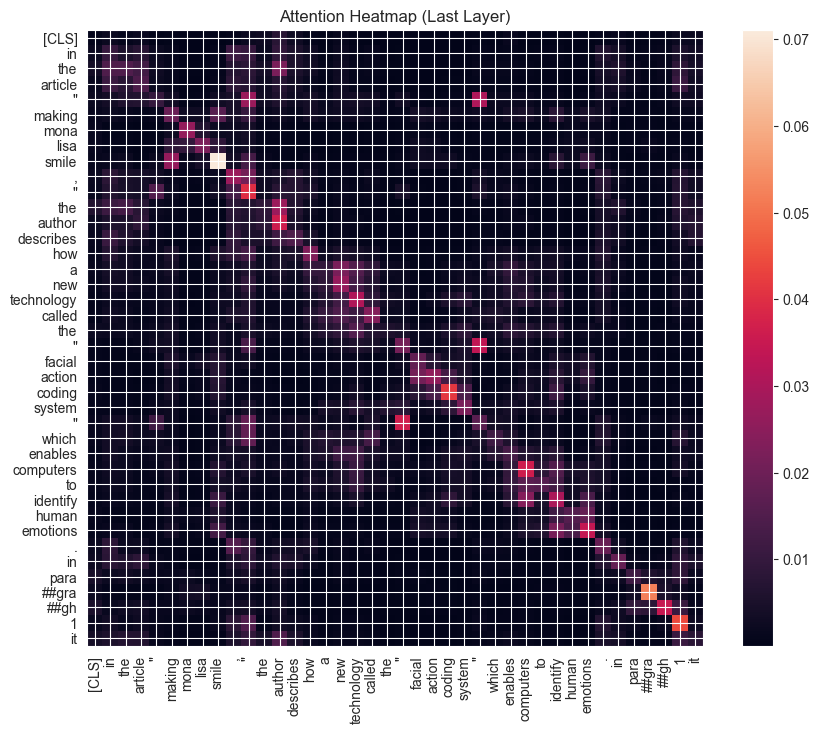

In [35]:
# Visualize attention
import matplotlib.pyplot as plt
import numpy as np

last_layer_attention = attentions[-1][0]  # first batch
avg_attention = last_layer_attention.mean(dim=0).numpy()

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

plt.figure(figsize=(10,8))
plt.imshow(avg_attention[:40, :40])
plt.xticks(range(40), tokens[:40], rotation=90)
plt.yticks(range(40), tokens[:40])
plt.title("Attention Heatmap (Last Layer)")
plt.colorbar()
plt.show()

In [38]:
# Ablation Studies (TF-IDF
# Orignially used ngram_range=(1,2)
#Lets compare: Unigrams only -> (1,1)
#Biagrams only -> (2,2)
# Unigrams + biagrams -> (1,2)

def run_ridge_experiment(ngram_range):
    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        max_features=20000,
        min_df=5
    )

    X_train = vectorizer.fit_transform(train["full_text"])
    X_val = vectorizer.transform(val["full_text"])
    X_test = vectorizer.transform(test["full_text"])

    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)

    preds = ridge.predict(X_test)
    return evaluate_model(y_test, preds)

results_unigram = run_ridge_experiment((1,1))
results_bigram = run_ridge_experiment((2,2))
results_both = run_ridge_experiment((1,2))

print("Unigrams only:", results_unigram)
print("Bigrams only:", results_bigram)
print("Unigrams + Bigrams:", results_both)


Unigrams only: (0.6953024612827983, 0.5386560609340462, np.float64(0.6774011012793554), np.float64(0.753553243665385))
Bigrams only: (0.7047547611166836, 0.5308227537461616, np.float64(0.6602641370322604), np.float64(0.7645871075064508))
Unigrams + Bigrams: (0.7302469914738804, 0.5061107001775033, np.float64(0.6347589624731087), np.float64(0.7860120113572238))


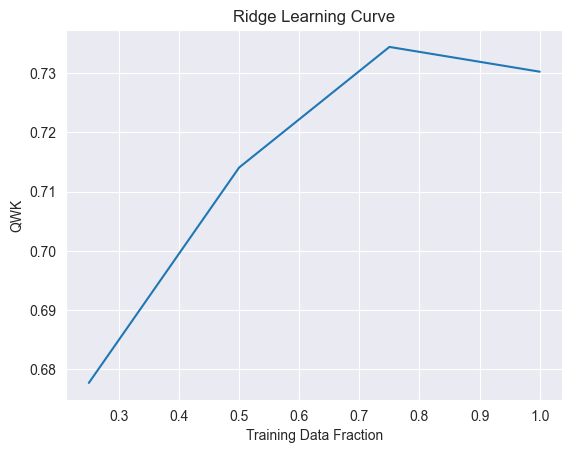

In [39]:
# Testing learning curves on 25% 50% 75% and 100% of the test data
fractions = [0.25, 0.5, 0.75, 1.0]
ridge_qwk_scores = []

for frac in fractions:
    subset = train.sample(frac=frac, random_state=42)

    vectorizer = TfidfVectorizer(
        ngram_range=(1,2),
        max_features=20000,
        min_df=5
    )

    X_train_sub = vectorizer.fit_transform(subset["full_text"])
    X_test_vec = vectorizer.transform(test["full_text"])

    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_sub, subset["score"])

    preds = ridge.predict(X_test_vec)
    qwk, _, _, _ = evaluate_model(y_test, preds)
    ridge_qwk_scores.append(qwk)

plt.plot(fractions, ridge_qwk_scores)
plt.xlabel("Training Data Fraction")
plt.ylabel("QWK")
plt.title("Ridge Learning Curve")
plt.show()

In [40]:
# Transformer Learning curve:
transformer_qwk_scores = []

for frac in fractions:
    subset = train.sample(frac=frac, random_state=42)
    subset_ds = Dataset.from_pandas(subset.reset_index(drop=True))
    subset_ds = subset_ds.rename_column("score", "labels")
    subset_ds = subset_ds.cast_column("labels", Value("float32"))
    subset_ds = subset_ds.map(tokenize, batched=True)
    subset_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    trainer = Trainer(
        model=AutoModelForSequenceClassification.from_pretrained(
            "distilbert-base-uncased",
            num_labels=1,
            problem_type="regression"
        ),
        args=training_args,
        train_dataset=subset_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics
    )

    trainer.train()
    metrics = trainer.evaluate(test_ds)
    transformer_qwk_scores.append(metrics["eval_qwk"])

Casting the dataset:   0%|          | 0/3030 [00:00<?, ? examples/s]

Map:   0%|          | 0/3030 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be

Epoch,Training Loss,Validation Loss,Qwk,Mae,Rmse,Spearman
1,0.595600,0.450451,0.708629,0.509336,0.671156,0.784158
2,0.453472,0.426042,0.706331,0.504709,0.652719,0.794289
3,0.332749,0.444557,0.732770,0.514615,0.666751,0.797724
4,0.255914,0.429094,0.742476,0.509357,0.655053,0.788381
5,0.192325,0.449675,0.738150,0.521177,0.670578,0.784320


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].
/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Casting the dataset:   0%|          | 0/6060 [00:00<?, ? examples/s]

Map:   0%|          | 0/6060 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be

Epoch,Training Loss,Validation Loss,Qwk,Mae,Rmse,Spearman
1,0.413586,0.507490,0.717038,0.546362,0.712383,0.802537
2,0.385669,0.418786,0.738774,0.503681,0.647137,0.804748
3,0.326884,0.403908,0.752561,0.491414,0.635537,0.809107
4,0.229419,0.400939,0.758140,0.487505,0.633198,0.804269
5,0.145912,0.418411,0.757507,0.495517,0.646847,0.799148


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].
/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Casting the dataset:   0%|          | 0/9091 [00:00<?, ? examples/s]

Map:   0%|          | 0/9091 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be

Epoch,Training Loss,Validation Loss,Qwk,Mae,Rmse,Spearman
1,0.472170,0.436483,0.735466,0.519332,0.660669,0.811045
2,0.424642,0.380762,0.785161,0.480587,0.617059,0.820390
3,0.250348,0.390388,0.768024,0.484323,0.624810,0.812424
4,0.205227,0.465202,0.752507,0.524635,0.682057,0.813839
5,0.157771,0.403076,0.766405,0.485929,0.634883,0.807549


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].
/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Casting the dataset:   0%|          | 0/12121 [00:00<?, ? examples/s]

Map:   0%|          | 0/12121 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be

Epoch,Training Loss,Validation Loss,Qwk,Mae,Rmse,Spearman
1,0.393265,0.427888,0.724093,0.511160,0.654131,0.819378
2,0.335256,0.356597,0.777773,0.460505,0.597157,0.826013


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/alberthmartin/PycharmProjects/ML_mini_project1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


KeyboardInterrupt: 